# Example EAST

The EAST object detector is inspired from [this pytorch implementation](https://github.com/SakuraRiven/EAST). The pre-processing has not been converted yet, so **the training procedure is not supported** yet. Nevertheless, the available pretrained model is well performing, and seems usable as is depending on the application ! (see below for examples). 

Furthermore, the model is fully integrated with the detection API, meaning that all the code shown in the `detection` notebook are usable with an EAST model.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from models import get_pretrained
from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.detection import EAST

model_name = 'east_text'

print('Tensorflow version : {}'.format(tf.__version__))

Tensorflow version : 2.10.0


In [2]:
model = EAST(
    nom    = model_name,
    labels = 'text',
    input_size = (None, None, 3),
    image_normalization = 'east',
    
    architecture = 'VGGBNUNet'
)

print(model)

Initializing model with kwargs : {'model': {'architecture_name': 'VGGBNUNet', 'input_shape': (None, None, 3), 'output_dim': [1, 4, 1], 'final_activation': ['sigmoid', 'sigmoid', 'sigmoid', 'softmax'], 'final_name': ['score_map', 'geo_map', 'theta_map', 'class_map']}}
Weights transfered successfully !
Initializing submodel : `model` !
Submodel model saved in pretrained_models\east_text\saving\model.json !
Model east_text initialized successfully !

========== east_text ==========
Sub model model
- Inputs 	: (None, None, None, 3)
- Outputs 	: [(None, None, None, 1), (None, None, None, 4), (None, None, None, 1)]
- Number of layers 	: 95
- Number of parameters 	: 15.099 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

- Image size : (None, None, 3)
- Resize config : {'antialias': True}
- Normalization style : east
- Labels (n = 1) : ['text']



## Model initialization + dataset loading

In [2]:
model = get_pretrained(model_name)

lr = {'name' : 'DivideByStep', 'maxval' : 1e-3, 'minval' : 1e-4}

model.compile(optimizer = 'adam', optimizer_config = {'lr' : lr}, loss_config = {'from_logits' : True})

Model restoration...
Initializing submodel : `model` !
Successfully restored model from pretrained_models/east_text/saving/model.json !
Model east_text initialized successfully !
Optimizer 'model_optimizer' initilized successfully !
Submodel model compiled !
  Loss : {'reduction': 'none', 'name': 'EASTLoss', 'from_logits': True, 'dice_smoothing': 0.01, 'geo_smoothing': 1.0, 'score_factor': 1.0, 'rbox_factor': 1.0, 'theta_factor': 10.0}
  Optimizer : {'name': 'Adam', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-04>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=0.001>}}, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : []


In [3]:
dataset = get_dataset('coco_text')

if isinstance(dataset, dict):
    train, valid = dataset['train'], dataset['valid']
else:
    train, valid = dataset, dataset

print('Dataset length :\n  Train length : {}\n  Valid length : {}'.format(
    len(train), len(valid)
))

Loading dataset coco_text...
Dataset length :
  Train length : 13880
  Valid length : 3261


## Training

In [ ]:
epochs     = 5
batch_size = 16

train_size   = 1024 * batch_size
shuffle_size = 0 if train is valid else batch_size * 16

model.train(
    train, validation_data = valid, epochs = epochs, batch_size = batch_size,
    train_size = train_size, valid_size = None,
    
    is_rectangular = False
)

In [ ]:
model.plot_history()
print(model.history)

## Prediction

Input shape  : (1, 384, 640, 3)
Output shape : [(1, 96, 160, 1), (1, 96, 160, 4), (1, 96, 160, 1)]
Boxes shape  : (1, 4, 2)


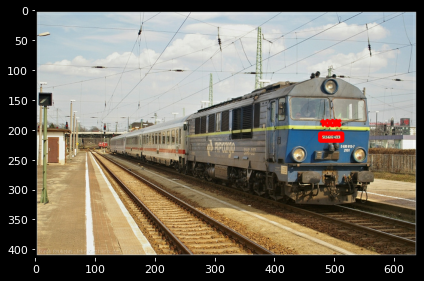

Input shape  : (1, 512, 640, 3)
Output shape : [(1, 128, 160, 1), (1, 128, 160, 4), (1, 128, 160, 1)]
Boxes shape  : (1, 4, 2)


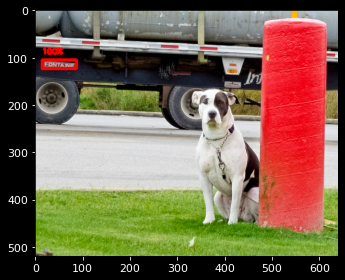

Input shape  : (1, 480, 352, 3)
Output shape : [(1, 120, 88, 1), (1, 120, 88, 4), (1, 120, 88, 1)]
Boxes shape  : (2, 4, 2)


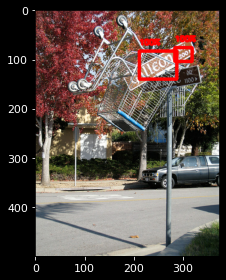

Input shape  : (1, 480, 640, 3)
Output shape : [(1, 120, 160, 1), (1, 120, 160, 4), (1, 120, 160, 1)]
Boxes shape  : (13, 4, 2)


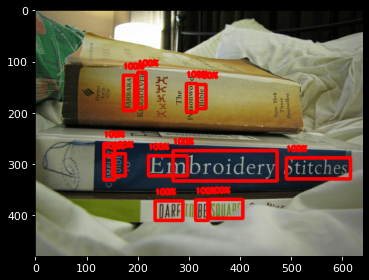

Input shape  : (1, 416, 640, 3)
Output shape : [(1, 104, 160, 1), (1, 104, 160, 4), (1, 104, 160, 1)]
Boxes shape  : (1, 4, 2)


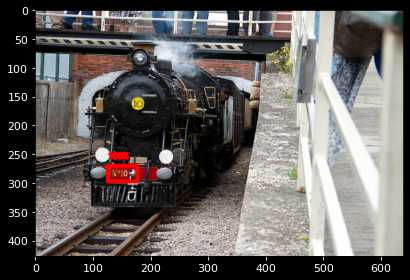

In [11]:
from utils import plot

for idx, row in valid.sample(5, random_state = 0).iterrows():
    inp = model.preprocess_input(tf.expand_dims(model.get_input(row), axis = 0))
    print('Input shape  : {}'.format(inp.shape))
    
    out = model.detect(inp, training = False, get_boxes = False)
    print('Output shape : {}'.format([tuple(o.shape) for o in out]))
    
    boxes = model.decode_output(out)[0]
    print('Boxes shape  : {}'.format(boxes.shape))
    
    plot(model.draw_prediction(row['filename'], boxes, color = 'red', thickness = 5))

## Test prediction with dataset

**Currently not working as the pre-processing compatible with the new post-processing used has not been implemented yet**

In [ ]:
config = model.get_dataset_config(batch_size = 1)

ds = prepare_dataset(train, ** config, is_rectangular = False)

for inp, out in ds.take(3):
    pred = model(inp)
    
    plot_multiple(
        score_map = out[0][0],
        pred_score = pred[0][0],
        d0_map = out[1][0, ..., 0],
        d0_pred = pred[1][0, ..., 0] * 512,
        plot_type = 'imshow'
    )

## Dataset

In [ ]:
from datasets import *
from loggers import set_level

set_level('debug', 'datasets')

config = model.get_dataset_config(batch_size = 16)

dataset = get_dataset('coco_text', modes = 'valid')
ds = prepare_dataset(dataset, ** config, is_rectangular = False)

set_level('info', 'datasets')

test_dataset_time(ds)

In [ ]:
config = model.get_dataset_config(batch_size = 16)

ds = prepare_dataset(train, ** config, is_rectangular = False)

for inp, out in ds.take(10):
    print('{} - {} - {} - {}'.format(
        out[0].shape, tf.reduce_any(tf.math.is_nan(out[0])), tf.reduce_min(out[0]), tf.reduce_max(out[0])
    ))
    print('{} - {} - {} - {}'.format(
        out[1].shape, tf.reduce_any(tf.math.is_nan(out[1])), tf.reduce_min(out[1][..., :4]), tf.reduce_max(out[1][..., :4])
    ))
    #out = model(inp)
    #print('{} - {} - {}'.format(out[0].shape, tf.reduce_any(tf.math.is_nan(out[0])), tf.reduce_max(out[0])))
    #print('{} - {} - {}'.format(out[1].shape, tf.reduce_any(tf.math.is_nan(out[1])), tf.reduce_min(out[1][..., :4])))
    print()

## Other test

In [ ]:
import importlib

from custom_architectures import unet_arch

importlib.reload(unet_arch)

model = unet_arch.VGGUNet((512, 512, 3), 1, n_stages = 5)
print(model.output_shape)
model.summary()


In [ ]:
from utils.image import *

for _, row in dataset.sample(5, random_state = 0).iterrows():
    masks = [np.array(m) for m in row['mask']]
    boxes = [np.maximum(0, np.array(b)) for b in row['box']]
    texts = row['label']

    print(texts)
    print(masks)
    img = load_image(row['filename'])
    plot_multiple(
        image = img, 
        mask = mask_utils.create_poly_mask(img, masks),
        bbox = box_utils.box_as_mask(img, boxes),
        plot_type = 'imshow', ncols = 3, size = 3
    )
    box_utils.show_boxes(img, boxes, labels = texts)